In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pandas import DataFrame as df
import seaborn as sns

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Load data
with open("RML2016.10a_dict.pkl", 'rb') as file:
    Xd = pickle.load(file, encoding='bytes')

snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1, 0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod, snr)])
        for i in range(Xd[(mod, snr)].shape[0]):
            lbl.append((mod, snr))
X = np.vstack(X)

In [ ]:
# Create features
features = {}
features['raw'] = X[:, 0], X[:, 1]
features['derivative'] = (np.gradient(X[:, 0], axis=1), np.gradient(X[:, 1], axis=1))
features['integral'] = (np.cumsum(X[:, 0], axis=1), np.cumsum(X[:, 1], axis=1))

def extract_features(*arguments):
    desired = ()
    for arg in arguments:
        desired += features[arg]
    return np.stack(desired, axis=1)

In [7]:
# Extract features and prepare labels
data = extract_features('raw')
y = np.array([x[0] for x in lbl])
snrs = np.array([x[1] for x in lbl]).astype(int)

In [8]:
# Split data
X_train, X_test, y_train, y_test, snr_train, snr_test = train_test_split(
    data, y, snrs, test_size=0.3, random_state=10, stratify=y
)


In [9]:
# Binarize labels
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)

c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:367: FutureWarning: Support for labels represented as bytes is deprecated in v1.5 and will error in v1.7. Convert the labels to a string or integer format.
  warnings.warn(
c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:367: FutureWarning: Support for labels represented as bytes is deprecated in v1.5 and will error in v1.7. Convert the labels to a string or integer format.
  warnings.warn(
c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:367: FutureWarning: Support for labels represented as bytes is deprecated in v1.5 and will error in v1.7. Convert the labels to a string or integer format.
  warnings.warn(
c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:367: FutureWarning: Support for labels represented as bytes is deprecated

In [10]:
# Convert to PyTorch tensors and move to device
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

In [11]:
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
# Define ANN model
class ANN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(ANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape[0] * input_shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.model(x)


In [13]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.ZeroPad2d((0, 2)),
            nn.Conv2d(1, 256, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.conv2 = nn.Sequential(
            nn.ZeroPad2d((0, 2)),
            nn.Conv2d(256, 80, kernel_size=(2, 3)),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc = nn.Sequential(
            nn.Linear(80 * 1 * 128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


In [14]:

# Training function
def train_model(model, train_loader, test_loader, epochs, patience=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}')
        
        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_model_{model.__class__.__name__}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break
    
    # Load best model
    model.load_state_dict(torch.load(f'best_model_{model.__class__.__name__}.pth'))
    return model

In [15]:
# Initialize models
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

ann_model = ANN(input_shape, num_classes)
cnn_model = CNN(input_shape, num_classes)

In [16]:
# Train ANN
print("Training ANN...")
ann_model = train_model(ann_model, train_loader, test_loader, epochs=30)
torch.save(ann_model.state_dict(), 'ann.pth')

Training ANN...
Epoch 1, Train Loss: 2.3808, Val Loss: 2.3544
Epoch 2, Train Loss: 2.3454, Val Loss: 2.3400
Epoch 3, Train Loss: 2.3374, Val Loss: 2.3376
Epoch 4, Train Loss: 2.3355, Val Loss: 2.3366
Epoch 5, Train Loss: 2.3346, Val Loss: 2.3361
Epoch 6, Train Loss: 2.3338, Val Loss: 2.3355
Epoch 7, Train Loss: 2.3326, Val Loss: 2.3332
Epoch 8, Train Loss: 2.3282, Val Loss: 2.3278
Epoch 9, Train Loss: 2.3234, Val Loss: 2.3214
Epoch 10, Train Loss: 2.3128, Val Loss: 2.3108
Epoch 11, Train Loss: 2.3060, Val Loss: 2.3072
Epoch 12, Train Loss: 2.3005, Val Loss: 2.3016
Epoch 13, Train Loss: 2.2953, Val Loss: 2.2967
Epoch 14, Train Loss: 2.2919, Val Loss: 2.2947
Epoch 15, Train Loss: 2.2899, Val Loss: 2.2934
Epoch 16, Train Loss: 2.2890, Val Loss: 2.2928
Epoch 17, Train Loss: 2.2878, Val Loss: 2.2925
Epoch 18, Train Loss: 2.2865, Val Loss: 2.2913
Epoch 19, Train Loss: 2.2856, Val Loss: 2.2909
Epoch 20, Train Loss: 2.2848, Val Loss: 2.2916
Epoch 21, Train Loss: 2.2840, Val Loss: 2.2894
Epoch 

In [17]:
# Train CNN
print("\nTraining CNN...")
cnn_model = train_model(cnn_model, train_loader, test_loader, epochs=30)
torch.save(cnn_model.state_dict(), 'cnn.pth')


Training CNN...
Epoch 1, Train Loss: 2.3980, Val Loss: 2.3979
Epoch 2, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 3, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 4, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 5, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 6, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 7, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 8, Train Loss: 2.3979, Val Loss: 2.3979


KeyboardInterrupt: 

c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:367: FutureWarning: Support for labels represented as bytes is deprecated in v1.5 and will error in v1.7. Convert the labels to a string or integer format.
  warnings.warn(
c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:367: FutureWarning: Support for labels represented as bytes is deprecated in v1.5 and will error in v1.7. Convert the labels to a string or integer format.
  warnings.warn(
c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:367: FutureWarning: Support for labels represented as bytes is deprecated in v1.5 and will error in v1.7. Convert the labels to a string or integer format.
  warnings.warn(
c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:367: FutureWarning: Support for labels represented as bytes is deprecated

Training ANN...
Epoch 1, Train Loss: 2.3826, Val Loss: 2.3540
Epoch 2, Train Loss: 2.3453, Val Loss: 2.3396
Epoch 3, Train Loss: 2.3376, Val Loss: 2.3381
Epoch 4, Train Loss: 2.3361, Val Loss: 2.3368
Epoch 5, Train Loss: 2.3351, Val Loss: 2.3366

Training CNN...
Epoch 1, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 2, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 3, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 4, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 5, Train Loss: 2.3979, Val Loss: 2.3979

Evaluating both models...


c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


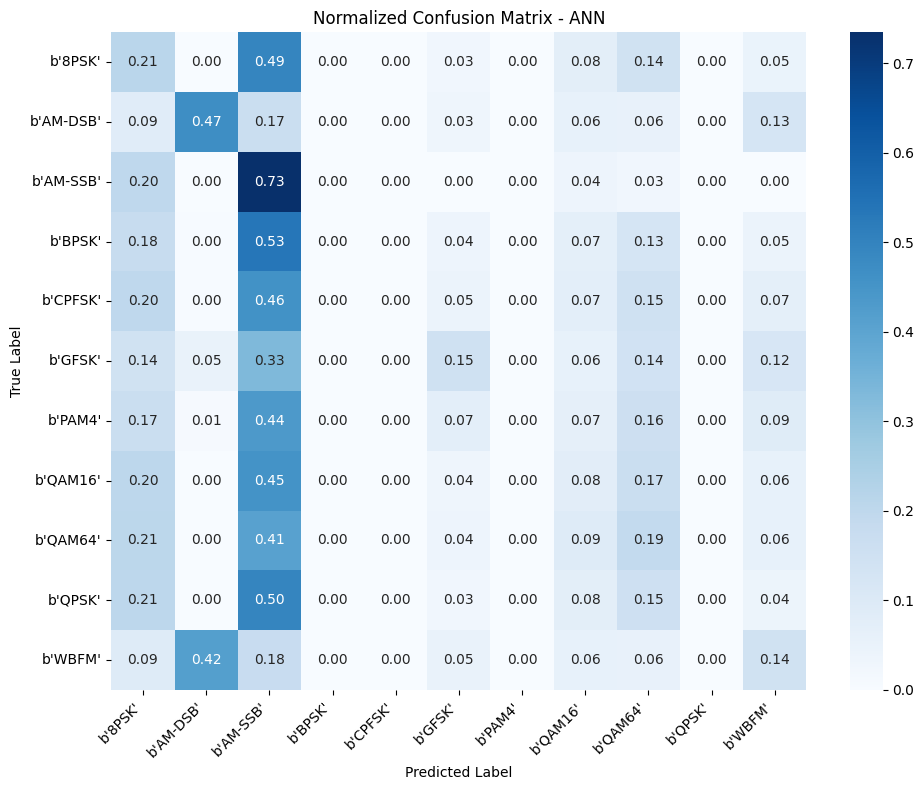

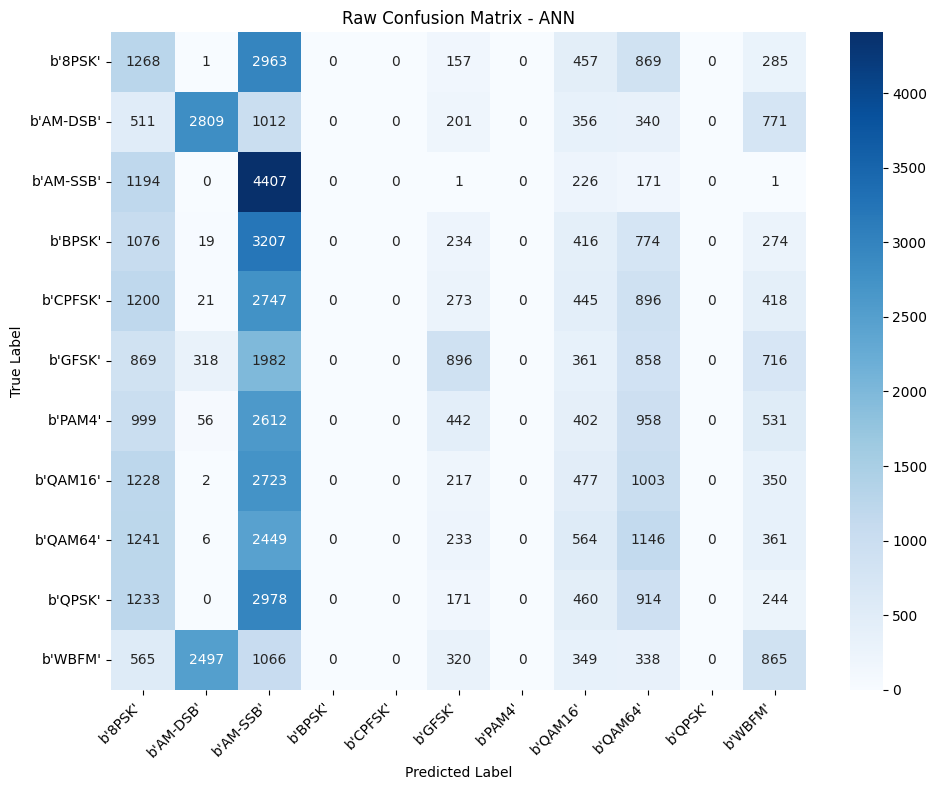

c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


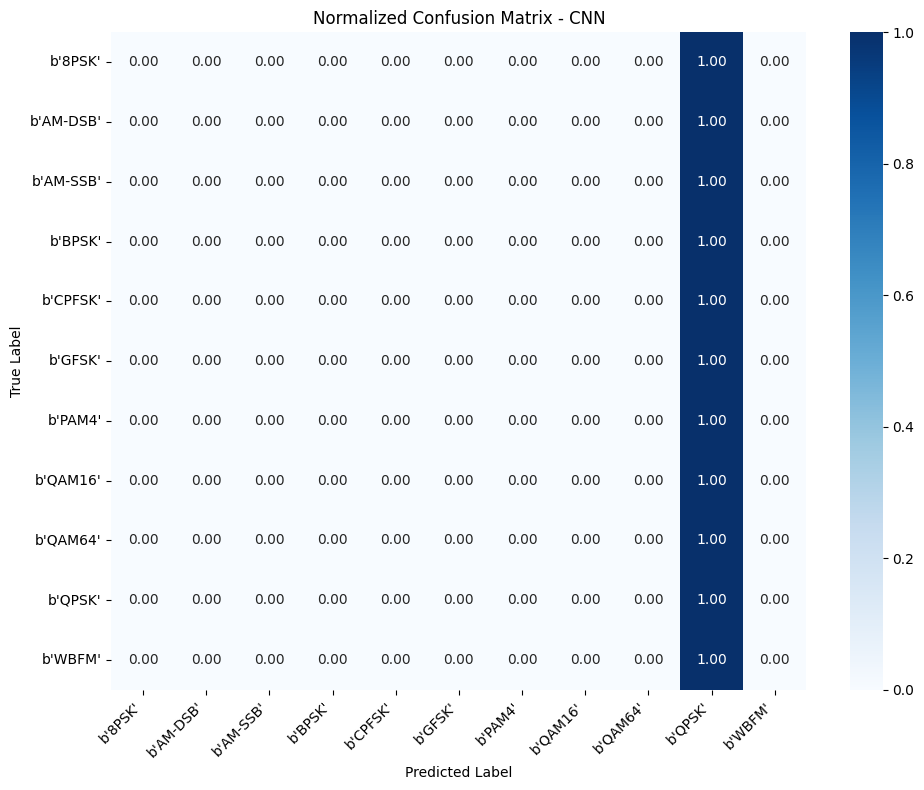

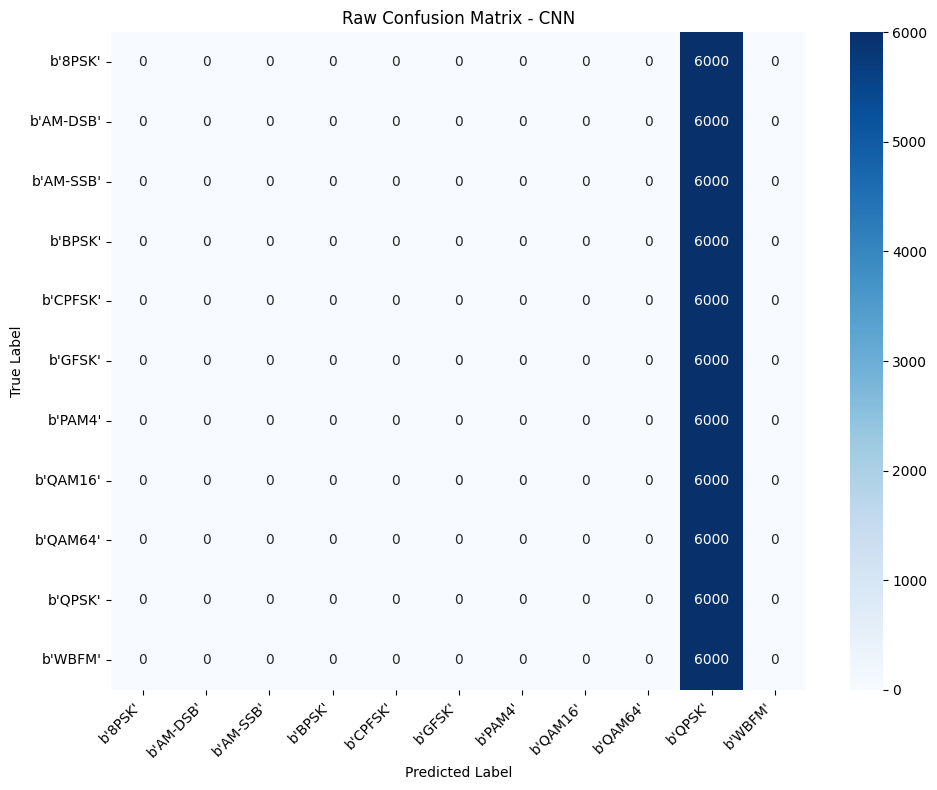


Model Performance Metrics:
                 ANN   CNN
Precision (%)  13.34  0.83
Recall (%)     17.98  9.09
F1-Score (%)   13.55  1.52

Accuracy per SNR:
      -20   -18   -16   -14    -12    -10    -8     -6     -4     -2      0   \
ANN  8.24  8.71  9.60  9.77  10.88  11.54  16.68  19.82  23.01  20.23  20.97   
CNN  9.04  9.68  9.19  8.88   8.84   9.06   8.52   9.17   9.05  10.55   8.48   

        2      4      6      8      10     12     14     16     18  
ANN  22.64  21.39  22.47  23.58  21.65  21.07  21.85  23.12  22.36  
CNN   8.64   8.92   9.36   8.73   9.20   9.47   9.59   8.23   9.23  


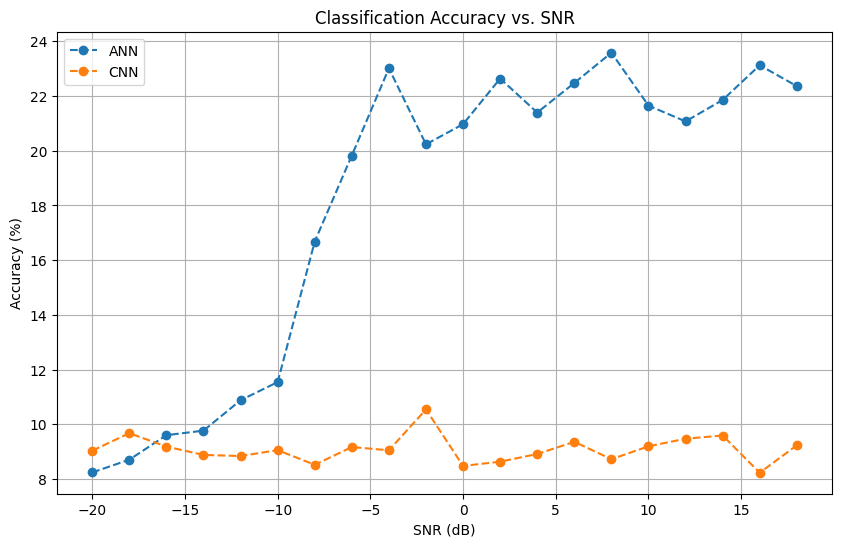

In [ ]:

# Evaluation function
def evaluate_models(models, model_names, X_test, y_test, snr_test, test_loader, classes):
    # Store results for all models
    all_results = {}
    all_metrics = {}
    sorted_snrs = np.sort(np.unique(snr_test))
    
    for model, name in zip(models, model_names):
        model.to(device)
        model.eval()
        y_pred = []
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                y_pred.append(outputs.cpu().numpy())
        y_pred = np.concatenate(y_pred, axis=0)
        
        # Calculate accuracy per SNR
        results = []
        for snr in sorted_snrs:
            idx = np.where(snr_test == snr)
            acc = accuracy_score(np.argmax(y_test[idx], axis=1), 
                               np.argmax(y_pred[idx], axis=1))
            results.append(acc * 100)
        all_results[name] = results
        
        # Calculate precision, recall, F1-score
        y_true = np.argmax(y_test, axis=1)
        y_pred_classes = np.argmax(y_pred, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
        all_metrics[name] = {'precision': precision, 'recall': recall, 'f1': f1}
        
        # Plot confusion matrix (normalized and raw)
        cm = confusion_matrix(y_true, y_pred_classes)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Normalized confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                   xticklabels=classes, yticklabels=classes)
        plt.title(f'Normalized Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Raw confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=classes, yticklabels=classes)
        plt.title(f'Raw Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    # Print metrics
    print("\nModel Performance Metrics:")
    metrics_df = df(data=[[all_metrics[name][metric] * 100 for name in model_names] 
                         for metric in ['precision', 'recall', 'f1']],
                   columns=model_names,
                   index=['Precision (%)', 'Recall (%)', 'F1-Score (%)']).round(2)
    print(metrics_df)
    
    # Print accuracy per SNR
    print("\nAccuracy per SNR:")
    accuracy_df = df(data=[all_results[name] for name in model_names],
                    columns=sorted_snrs,
                    index=model_names).round(2)
    print(accuracy_df)
    
    # Plot accuracy vs. SNR for all models
    plt.figure(figsize=(10, 6))
    for name in model_names:
        plt.plot(sorted_snrs, all_results[name], 'o--', label=name)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy (%)')
    plt.title('Classification Accuracy vs. SNR')
    plt.grid(True)
    plt.legend()
    plt.show()



In [ ]:
# Evaluate both models
print("\nEvaluating both models...")
evaluate_models([ann_model, cnn_model], ['ANN', 'CNN'], y_test, y_test, snr_test, test_loader, mods)

In [ ]:
import optuna

In [ ]:

# Objective function for ANN hyperparameter optimization
def objective_ann(trial):
    # Define hyperparameter search space
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [512, 1024, 2048])
    hidden1 = trial.suggest_int("hidden1", 64, 256, step=32)
    hidden2 = trial.suggest_int("hidden2", 128, 512, step=64)
    
    # Create data loader with suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)
    
    # Define ANN model with suggested architecture
    class ANN(nn.Module):
        def __init__(self, input_shape, num_classes, hidden1, hidden2):
            super(ANN, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_shape[0] * input_shape[1], hidden1),
                nn.ReLU(),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Linear(hidden2, 128),
                nn.ReLU(),
                nn.Linear(128, num_classes),
                nn.Softmax(dim=1)
            )
        
        def forward(self, x):
            x = x.view(x.size(0), -1)
            return self.model(x)
    
    # Initialize model
    model = ANN(input_shape, num_classes, hidden1, hidden2).to(device)
    
    # Define optimizer and loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    model.train()
    for epoch in range(3):  # Fixed epochs for optimization
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        # Report validation loss to Optuna
        trial.report(val_loss / len(test_loader), epoch)
        
        # Prune trial if necessary
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return val_loss / len(test_loader)


In [ ]:

# Objective function for CNN hyperparameter optimization
def objective_cnn(trial):
    # Define hyperparameter search space
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [512, 1024, 2048])
    conv1_filters = trial.suggest_int("conv1_filters", 64, 256, step=32)
    conv2_filters = trial.suggest_int("conv2_filters", 32, 128, step=16)
    
    # Create data loader with suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)
    
    # Define CNN model with suggested architecture
    class CNN(nn.Module):
        def __init__(self, input_shape, num_classes, conv1_filters, conv2_filters):
            super(CNN, self).__init__()
            self.conv1 = nn.Sequential(
                nn.ZeroPad2d((0, 2)),
                nn.Conv2d(1, conv1_filters, kernel_size=(1, 3)),
                nn.ReLU(),
                nn.Dropout(0.5)
            )
            self.conv2 = nn.Sequential(
                nn.ZeroPad2d((0, 2)),
                nn.Conv2d(conv1_filters, conv2_filters, kernel_size=(2, 3)),
                nn.ReLU(),
                nn.Dropout(0.5)
            )
            self.fc = nn.Sequential(
                nn.Linear(conv2_filters * 1 * 128, 256),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(256, num_classes),
                nn.Softmax(dim=1)
            )
        
        def forward(self, x):
            x = x.unsqueeze(1)
            x = self.conv1(x)
            x = self.conv2(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x
    
    # Initialize model
    model = CNN(input_shape, num_classes, conv1_filters, conv2_filters).to(device)
    
    # Define optimizer and loss
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    model.train()
    for epoch in range(3):  # Fixed epochs for optimization
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        # Report validation loss to Optuna
        trial.report(val_loss / len(test_loader), epoch)
        
        # Prune trial if necessary
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return val_loss / len(test_loader)


In [ ]:
# Run Optuna optimization for ANN
print("\nOptimizing ANN hyperparameters with Optuna...")
study_ann = optuna.create_study(direction="minimize")
study_ann.optimize(objective_ann, n_trials=20)

In [ ]:
# Train ANN with best hyperparameters
best_ann_params = study_ann.best_params
train_loader = DataLoader(train_dataset, batch_size=best_ann_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_ann_params['batch_size'])
ann_model = ANN(input_shape, num_classes, best_ann_params['hidden1'], best_ann_params['hidden2']).to(device)
optimizer = optim.Adam(ann_model.parameters(), lr=best_ann_params['lr'])
print("\nTraining ANN with best hyperparameters...")
ann_model = train_model(ann_model, train_loader, test_loader, epochs=10)
torch.save(ann_model.state_dict(), 'ann_optimized.pth')

In [ ]:
# Run Optuna optimization for CNN
print("\nOptimizing CNN hyperparameters with Optuna...")
study_cnn = optuna.create_study(direction="minimize")
study_cnn.optimize(objective_cnn, n_trials=20)

In [ ]:
# Train CNN with best hyperparameters
best_cnn_params = study_cnn.best_params
train_loader = DataLoader(train_dataset, batch_size=best_cnn_params['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_cnn_params['batch_size'])
cnn_model = CNN(input_shape, num_classes, best_cnn_params['conv1_filters'], best_cnn_params['conv2_filters']).to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr=best_cnn_params['lr'])
print("\nTraining CNN with best hyperparameters...")
cnn_model = train_model(cnn_model, train_loader, test_loader, epochs=8)
torch.save(cnn_model.state_dict(), 'cnn_optimized.pth')

In [ ]:
# Evaluate optimized models
print("\nEvaluating optimized models...")
evaluate_models([ann_model, cnn_model], ['Optimized ANN', 'Optimized CNN'], X_test, y_test, snr_test, test_loader, mods)

In [ ]:

# Print best hyperparameters
print("\nBest ANN hyperparameters:", study_ann.best_params)
print("Best ANN validation loss:", study_ann.best_value)
print("\nBest CNN hyperparameters:", study_cnn.best_params)
print("Best CNN validation loss:", study_cnn.best_value)

[I 2025-05-30 21:08:43,733] A new study created in memory with name: no-name-8eaf8002-716d-48c9-a880-4ac2949e49eb



Optimizing ANN hyperparameters with Optuna...


[I 2025-05-30 21:08:55,455] Trial 0 finished with value: 2.335941923581637 and parameters: {'lr': 0.0013404525393562023, 'batch_size': 1024, 'hidden1': 192, 'hidden2': 256}. Best is trial 0 with value: 2.335941923581637.
[I 2025-05-30 21:09:06,834] Trial 1 finished with value: 2.396950047145518 and parameters: {'lr': 1.6021086416991423e-05, 'batch_size': 512, 'hidden1': 192, 'hidden2': 384}. Best is trial 0 with value: 2.335941923581637.
[I 2025-05-30 21:09:18,902] Trial 2 finished with value: 2.2436948857566184 and parameters: {'lr': 0.008977722802832665, 'batch_size': 512, 'hidden1': 192, 'hidden2': 192}. Best is trial 2 with value: 2.2436948857566184.
[I 2025-05-30 21:09:30,216] Trial 3 finished with value: 2.334415714557354 and parameters: {'lr': 0.001266132601304473, 'batch_size': 1024, 'hidden1': 96, 'hidden2': 512}. Best is trial 2 with value: 2.2436948857566184.
[I 2025-05-30 21:09:40,179] Trial 4 finished with value: 2.3370383941765986 and parameters: {'lr': 0.0070045387671635

TypeError: ANN.__init__() takes 3 positional arguments but 5 were given